In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from pandas import DataFrame

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from scipy import interp

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
G = nx.read_gpickle("static/data/Whole.pickle") ## Load Network 

In [3]:
nodes = list(G.nodes())
edges = list(G.edges())

In [4]:
def getRandomEdges(n, nodes, edges, ratio = 0.1):
    ## 네트워크에서 random node pair를 선택해서 training set를 생성하는 함수, ratio는 link가 있는 것과 없는 것의 비율 
    res = []
    for i in range(int(n * (1 - ratio))):
        while(True):
            geneA = random.choice(nodes)
            geneB = random.choice(nodes)
            if geneA != geneB:
                break
        cur = (geneA, geneB)
        if cur not in res:
            res.append(cur)
    
    cnt = 0
    for i in edges:
        if i not in res:
            cnt += 1 
            res.append(i)
            if cnt == int(n * ratio):
                break
                
    random.shuffle(res)
    return res

In [5]:
train = getRandomEdges(10000, nodes, edges, 0.3)
test = getRandomEdges(1000, nodes, edges, 0.3)

## train, test 데이터 생성 

In [6]:
pref_train = list(nx.preferential_attachment(G, train))
jacc_train = list(nx.jaccard_coefficient(G, train))
isin_train = list(map(int, [edg in edges for edg in train]))
pref_test = list(nx.preferential_attachment(G, test))
jacc_test = list(nx.jaccard_coefficient(G, test))
isin_test = list(map(int, [edg in edges for edg in test]))

## networkx library를 활용하여 preferential attatchment, jacard coefficient, edge 여부 계산하여 Feature matrix 생성 

In [7]:
df_train = []
for i in range(len(train)):
    cur = [pref_train[i][2], jacc_train[i][2], isin_train[i]]
    df_train.append(cur)

df_test = []
for i in range(len(test)):
    cur = [pref_test[i][2], jacc_test[i][2], isin_test[i]]
    df_test.append(cur)

In [8]:
df_train = DataFrame(df_train, columns = ["pref", "jacc", "isConnected"])
df_test = DataFrame(df_test, columns = ["pref", "jacc", "isConnected"])

In [11]:
X = df_train.drop(columns = ["isConnected"])
y = df_train["isConnected"]
X_test = df_test.drop(columns = ["isConnected"])
y_test = df_test['isConnected']

## X, y 값을 만들고 

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99


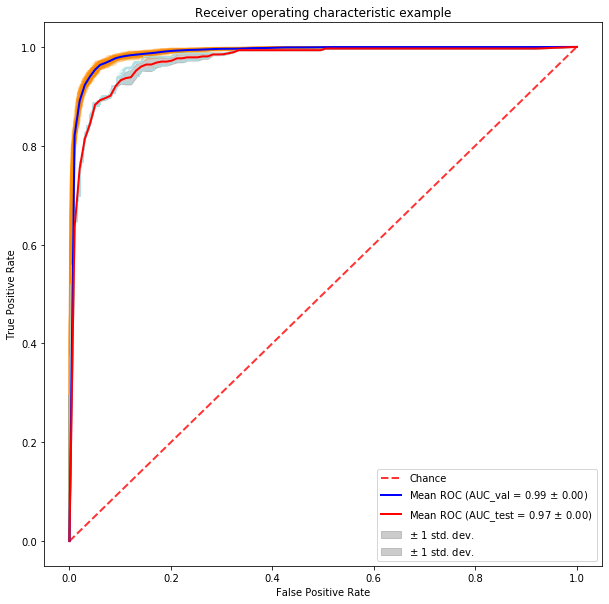

In [15]:
models = [] 

val_tprs = []
val_aucs = []
test_tprs = []
test_aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize = (10, 10))
## AUC curve를 그리는 코드 

## Training 시작 
for i in range(100):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify = y)
    ## 전체 training set 중 train : validation 비율을 7:3으로 하여 training 
    ## Logistic regression model 생성 
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_score = clf.predict_proba(X_val)[:, 1]
    y_score2 = clf.predict_proba(X_test)[:, 1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_val, y_score)
    val_tprs.append(interp(mean_fpr, fpr, tpr))
    val_tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    val_aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='darkorange', lw=1, alpha = 0.2)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score2)
    test_tprs.append(interp(mean_fpr, fpr, tpr))
    test_tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    test_aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='powderblue', lw=1, alpha = 0.2)
    
    models.append([clf, roc_auc, fpr, tpr])
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(val_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(val_aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC_val = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=1)

std_tpr = np.std(val_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
                 label=r'$\pm$ 1 std. dev.')


mean_tpr = np.mean(test_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(test_aucs)
plt.plot(mean_fpr, mean_tpr, color='r',
         label=r'Mean ROC (AUC_test = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=1)

std_tpr = np.std(test_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.4,
                 label=r'$\pm$ 1 std. dev.')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [25]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)
### 모델 저장 

In [26]:
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [28]:
pickle_model.score(X, y)

0.9416